In [2]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np

In [3]:
# Set Constants
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
CHANNELS = 3
EPOCHS = 30

In [4]:
# Define a function to split the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    "..\PlantVillage",
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training"
)

Found 8603 files belonging to 8 classes.
Using 6883 files for training.


In [6]:
class_names = dataset.class_names
class_names

['Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy']

In [7]:
# Split dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
# Cache, shuffle, and prefetch the dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [9]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

    layers.experimental.preprocessing.RandomContrast(factor=(0.5, 1.5)),

    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=AUTOTUNE)

In [10]:
# Model Architecture
input_shape = IMAGE_SIZE + (CHANNELS,)
n_classes = len(class_names)

# Load EfficientNet B0 pre-trained on ImageNet
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=input_shape
)

# Freeze only the bottom layers for faster convergence
for layer in base_model.layers[:100]: 
    layer.trainable = False

# Create a sequential model with base model and new layers
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'), 
    layers.Dense(n_classes, activation='softmax')
])

In [11]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
# Define an EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,             # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore best model weights when stopping
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)

Epoch 1/30


172/172 [==============================] - 352s 2s/step - loss: 0.1678 - accuracy: 0.9501 - val_loss: 0.1209 - val_accuracy: 0.9702
Epoch 2/30
172/172 [==============================] - 283s 2s/step - loss: 0.0562 - accuracy: 0.9832 - val_loss: 0.0336 - val_accuracy: 0.9955
Epoch 3/30
172/172 [==============================] - 249s 1s/step - loss: 0.0525 - accuracy: 0.9847 - val_loss: 0.0079 - val_accuracy: 0.9970
Epoch 4/30
172/172 [==============================] - 254s 1s/step - loss: 0.0384 - accuracy: 0.9894 - val_loss: 0.0127 - val_accuracy: 0.9955
Epoch 5/30
172/172 [==============================] - 260s 2s/step - loss: 0.0362 - accuracy: 0.9896 - val_loss: 0.0063 - val_accuracy: 0.9985
Epoch 6/30
172/172 [==============================] - 258s 1s/step - loss: 0.0193 - accuracy: 0.9940 - val_loss: 0.0272 - val_accuracy: 0.9940
Epoch 7/30
172/172 [==============================] - 264s 2s/step - loss: 0.0201 - accuracy: 0.9934 - val_loss: 0.0144 - val_accuracy: 0.99

In [13]:
# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)

print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

23/23 [==============================] - 20s 612ms/step - loss: 0.0026 - accuracy: 1.0000
Test loss: 0.002646359149366617
Test accuracy: 1.0


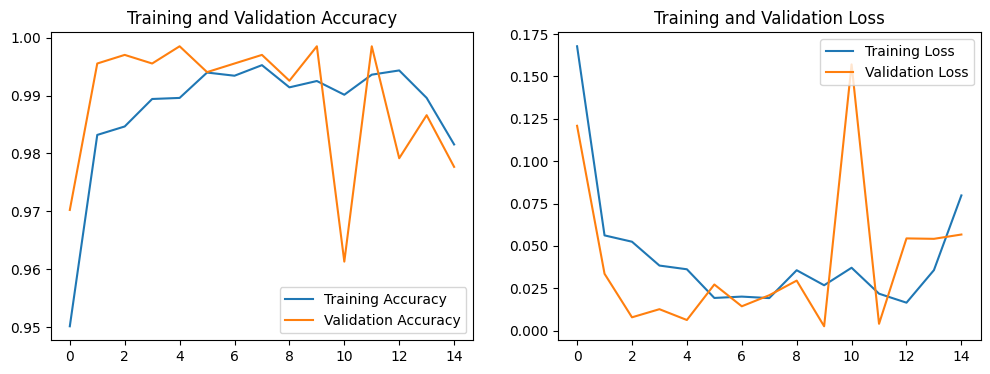

23/23 [==============================] - 16s 615ms/step


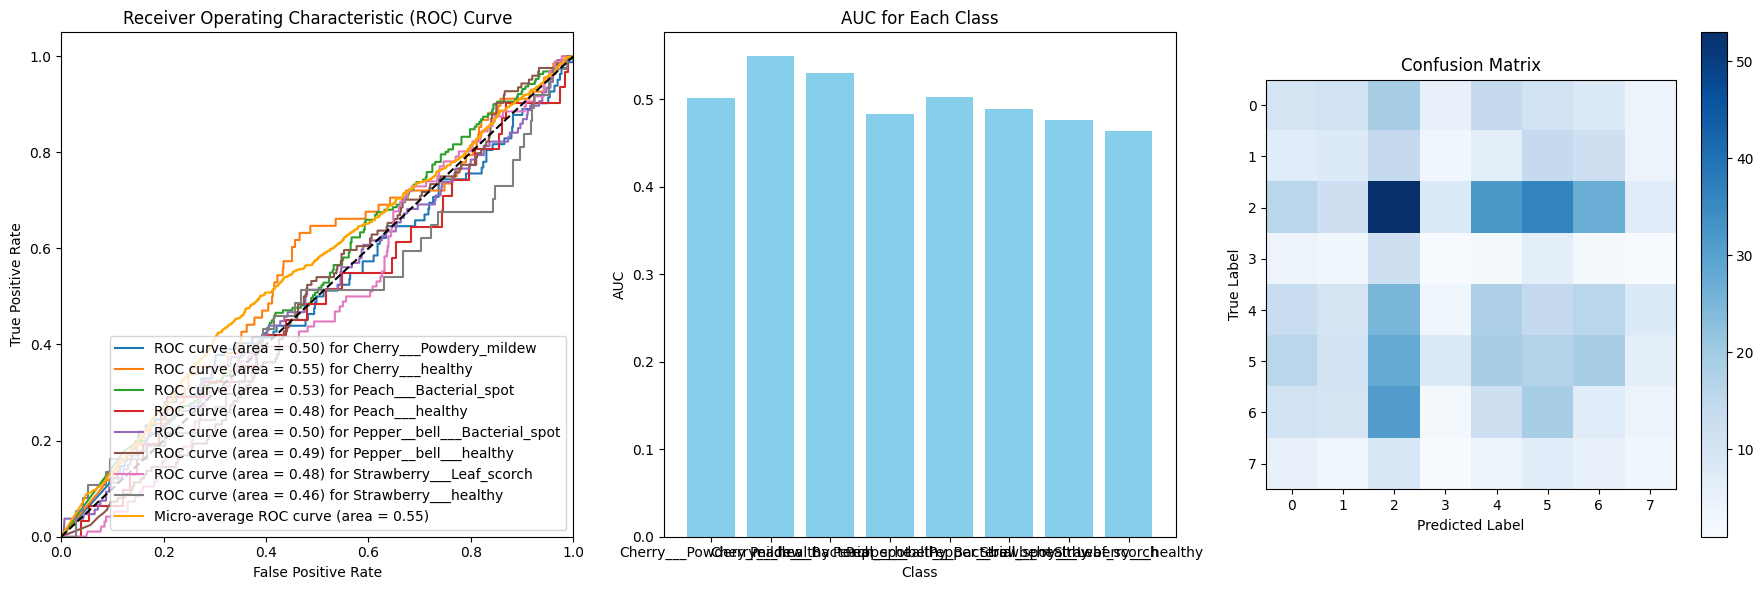

Classification Report:
                               precision    recall  f1-score   support

      Cherry___Powdery_mildew       0.12      0.12      0.12        82
             Cherry___healthy       0.12      0.12      0.12        68
       Peach___Bacterial_spot       0.28      0.28      0.28       191
              Peach___healthy       0.03      0.03      0.03        31
Pepper__bell___Bacterial_spot       0.17      0.17      0.17       107
       Pepper__bell___healthy       0.14      0.14      0.14       124
     Strawberry___Leaf_scorch       0.07      0.07      0.07        96
         Strawberry___healthy       0.08      0.08      0.08        37

                     accuracy                           0.16       736
                    macro avg       0.13      0.13      0.13       736
                 weighted avg       0.16      0.16      0.16       736



In [14]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS=len(acc)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Plot metrics
def plot_metrics(model, test_ds, class_names):
    y_true = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)
    y_scores = model.predict(test_ds)
    y_true_binary = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr_micro, tpr_micro, _ = roc_curve(y_true_binary.ravel(), y_scores.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i in range(len(class_names)):
        axes[0].plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_names[i]}')

    axes[0].plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})', color='orange')
    axes[0].plot([0, 1], [0, 1], 'k--')
    
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc="lower right")

    axes[1].bar(class_names, roc_auc.values(), color='skyblue')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('AUC')
    axes[1].set_title('AUC for Each Class')

    y_pred_labels = np.argmax(y_scores, axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred_labels)

    im = axes[2].imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    axes[2].set_title('Confusion Matrix')
    axes[2].set_xlabel('Predicted Label')
    axes[2].set_ylabel('True Label')
    fig.colorbar(im, ax=axes[2])

    plt.tight_layout()
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred_labels, target_names=class_names))

plot_metrics(model, test_ds, class_names)

In [15]:
# model.save('plant_model.h5')

In [18]:
model.save('..\plant_model', save_format='tf')

INFO:tensorflow:Assets written to: ..\plant_model\assets


INFO:tensorflow:Assets written to: ..\plant_model\assets


In [17]:
import os
model_version = max([int(i) for i in (os.listdir("..\models")+[0])]) + 1
model.save(f"..\models\{model_version}")

INFO:tensorflow:Assets written to: ..\models\2\assets


INFO:tensorflow:Assets written to: ..\models\2\assets
